In [1]:
##Importing packages
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
from scipy.stats import multivariate_normal as mvn

In [2]:
##Visualizing the data
df=pd.read_csv('/content/drive/MyDrive/EnhanceIT/data_cleansed.csv')
#df.head(5)

In [3]:
##Dropping unnecessary columns
df.drop(['Unnamed: 0', 'HOA', 'kitchen_features', 'floor_covering'], axis=1, inplace=True)

In [4]:
#Making additional cleaning
df['bedrooms']=df['bedrooms'].astype(int)
df['bathrooms']=df['bathrooms'].astype(int)
df = df[~(df['lot_acres'] > 10)]
df = df[~(df['lot_acres']==0)]
df = df[~(df['taxes'] >1.0e7)]
df = df[~(df['taxes'] >6.0e5)]

In [5]:
df

,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,fireplaces
0,2000000.0,85750,-110.848679,32.321134,0.64,11322.00,2001,5,6,7471.0,3,5.0
1,1900000.0,85750,-110.843910,32.328460,1.16,16714.00,2002,4,4,5333.0,3,2.0
2,1800000.0,85750,-110.845560,32.327714,1.32,20206.00,2002,4,7,6800.0,3,4.0
3,1950000.0,85755,-110.992676,32.464204,1.18,21063.00,2002,4,6,6622.0,6,3.0
4,1920000.0,85718,-110.910653,32.338271,1.27,24316.00,1997,5,6,7132.0,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4479,535000.0,85718,-110.922291,32.317496,0.18,4414.00,2002,3,2,2106.0,2,1.0
4480,495000.0,85641,-110.661829,31.907917,4.98,2017.00,2005,5,3,3601.0,3,1.0
4481,550000.0,85750,-110.858556,32.316373,1.42,4822.01,1990,4,3,2318.0,3,1.0
4482,550000.0,85745,-111.055528,32.296871,1.01,5822.93,2009,4,4,3724.0,3,1.0


In [6]:
df[['sqrt_ft','bedrooms','bathrooms']]

,sqrt_ft,bedrooms,bathrooms
0,7471.0,5,6
1,5333.0,4,4
2,6800.0,4,7
3,6622.0,4,6
4,7132.0,5,6
...,...,...,...
4479,2106.0,3,2
4480,3601.0,5,3
4481,2318.0,4,3
4482,3724.0,4,4


In [7]:
df.shape

(4484, 12)

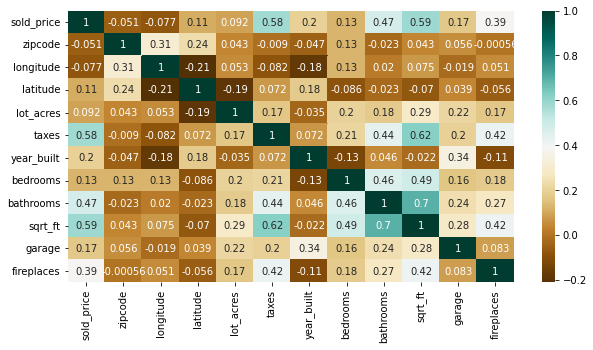

In [8]:
plt.figure(figsize=(10,5))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)


In [83]:
#Taking the columns used in the model
#df1=df.sample(frac=1) #Shuffle the data
X=df[['sqrt_ft','bedrooms']]
X

,sqrt_ft,bedrooms
0,7471.0,5
1,5333.0,4
2,6800.0,4
3,6622.0,4
4,7132.0,5
...,...,...
4479,2106.0,3
4480,3601.0,5
4481,2318.0,4
4482,3724.0,4


In [84]:
##Normalizing the data
X=(X-X.min())/(X.max()-X.min())

In [11]:
#Converting the data to array
X=X.to_numpy()
#Defining the dependent variable to classify
y=df.bathrooms.to_numpy()

In [12]:
#Dividing the data in training, validation and test
X_train=X[:3363,:]
y_train=y[:3363]
X_test=X[3363:4036,:]
y_test=y[3363:4036]
X_val=X[4036:,:]
y_val=y[4036:]

In [13]:
##Defining the algorithm
class KNNClassifier():
  def fit(self,X,y):
    self.X=X
    self.y=y
  
  def predict(self,X,K,epsilon=1e-3):

    N=len(X)
    y_hat=np.zeros(N)

    for i in range(N):
      dist2= np.sum((self.X-X[i])**2, axis=1)
      idxt = np.argsort(dist2)[:K]
      gamma_k=1/(np.sqrt(dist2[idxt]+epsilon))
      y_hat[i]= np.bincount(self.y[idxt], weights=gamma_k).argmax()
    
    return y_hat

In [14]:
##Defining the accuracy function
def accuracy(y,y_hat):
  return np.mean(y==y_hat)

In [15]:
#Fitting the model with the training data
knn = KNNClassifier()
knn.fit(X_train,y_train)
y_hat_train=knn.predict(X_train,10)

In [16]:
#Accuracy of the training model for K=10 neighbors
accuracy(y_train, y_hat_train)

0.6369313113291704

In [17]:
#Defining functions of K-neighbors to get the accueracy
def ac1(N):
  y_hat_train=knn.predict(X_train,N)
  return accuracy(y_train,y_hat_train)
neigh1=[i for i in range(1,150)]
accs1=np.zeros(len(neigh1))
for i in range(len(neigh1)):
  accs1[i]=ac1(neigh1[i])

In [18]:
def ac(N):
  y_hat_val=knn.predict(X_val,N)
  return accuracy(y_val,y_hat_val)
neigh=[i for i in range(1,150)]
accs=np.zeros(len(neigh))
for i in range(len(neigh)):
  accs[i]=ac(neigh[i])

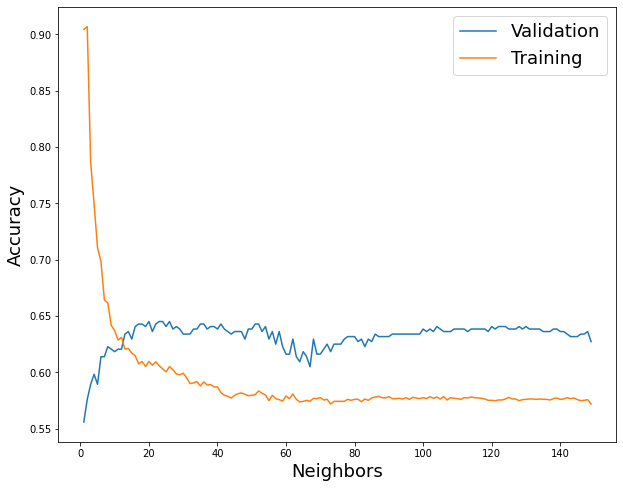

In [19]:
plt.figure(figsize=(10,8))
plt.clf()
plt.plot(neigh,accs,label='Validation')
plt.plot(neigh1,accs1,label='Training')
#plt.plot(best_e,max_acc,'*',markersize=20,label='Best model')
plt.xlabel('Neighbors',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.legend(fontsize=18)


In [20]:
#Creting a Data Frame to find the best K for the model
pd.DataFrame({'Neighbors': neigh1, 'accuracy_Train': accs, 'accuracy_Val': accs1})[10:20]


,Neighbors,accuracy_Train,accuracy_Val
10,11,0.620536,0.628605
11,12,0.620536,0.630984
12,13,0.633929,0.620577
13,14,0.636161,0.621172
14,15,0.629464,0.617009
15,16,0.640625,0.614630
16,17,0.642857,0.607493
17,18,0.642857,0.609575
18,19,0.640625,0.605114
19,20,0.645089,0.609575


In [21]:
#In this case we use K=24 neighbors to predict the test data
y_hat_test=knn.predict(X_test,16)
accuracy(y_test, y_hat_test)

0.6047548291233283

In [22]:
#Creating a data frame to compare the actual values with the predicted ones
results_test=pd.DataFrame({'Actual': y_test, 'prediction': y_hat_test})
results_test

,Actual,prediction
0,3,4.0
1,4,4.0
2,3,3.0
3,3,3.0
4,5,3.0
...,...,...
668,3,4.0
669,3,3.0
670,3,3.0
671,2,3.0


<function matplotlib.pyplot.show>

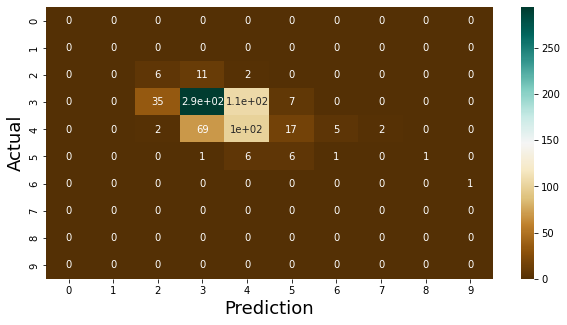

In [23]:
#Getting the confusion matrix of the Test data
confusion_matrix1=[]
for i in range(0,10):
  b=[]
  for j in range(0,10):
    x=results_test[(results_test['Actual']==j)&(results_test['prediction']==i)].shape[0]
    b.append(x)
  confusion_matrix1.append(b)
plt.figure(figsize=(10,5))
matrix=pd.DataFrame(confusion_matrix1)
sn.heatmap(matrix, cmap="BrBG",annot=True)
plt.xlabel('Prediction',fontsize=18)
plt.ylabel('Actual',fontsize=18)
plt.show

In [24]:
#Comparing the same with the Validation data
y_hat_val=knn.predict(X_val,24)
results_val=pd.DataFrame({'Actual': y_val, 'prediction': y_hat_val})
results_val.head(15)

,Actual,prediction
0,3,3.0
1,3,3.0
2,3,4.0
3,2,3.0
4,3,3.0
5,3,3.0
6,4,3.0
7,3,3.0
8,2,3.0
9,3,3.0


<function matplotlib.pyplot.show>

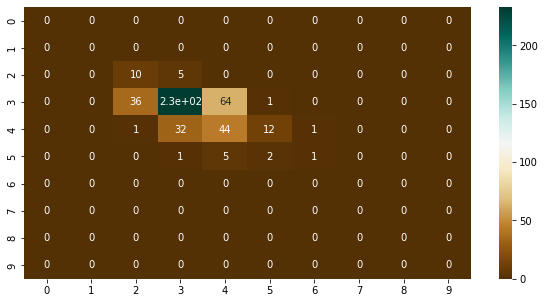

In [25]:
confusion_matrix2=[]
for i in range(0,10):
  b=[]
  for j in range(0,10):
    x=results_val[(results_val['Actual']==j)&(results_val['prediction']==i)].shape[0]
    b.append(x)
  confusion_matrix2.append(b)
plt.figure(figsize=(10,5))
matrix=pd.DataFrame(confusion_matrix2)
sn.heatmap(matrix, cmap="BrBG",annot=True)
plt.show

In [26]:
X

array([[0.99596706, 0.375     ],
       [0.63669971, 0.25      ],
       [0.88321291, 0.25      ],
       ...,
       [0.13006217, 0.25      ],
       [0.36632499, 0.25      ],
       [0.46597211, 0.25      ]])

In [27]:
Z=df[['sqrt_ft','bedrooms']]
Z_norm=(Z-Z.min())/(Z.max()-Z.min())
Y=df.bathrooms.to_numpy()
zz=Z_norm.to_numpy()
Y_Hat=knn.predict(zz,24)
Y_Hat
accuracy(Y,Y_Hat)

0.6070472792149866

In [28]:
cand=[]
c=0
for i in range(len(Y)):
  if Y_Hat[i]>Y[i]:
    cand.append(1)
    c=c+1
  else:
    cand.append(0)
print('The number of houses that can be candidates is', c)

The number of houses that can be candidates is 738


In [29]:
Z['bathrooms']=Y
Z['predicted']=Y_Hat
Z['candidate']=cand

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [30]:
Z.head(5)

,sqrt_ft,bedrooms,bathrooms,predicted,candidate
0,7471.0,5,6,6.0,0
1,5333.0,4,4,5.0,1
2,6800.0,4,7,6.0,0
3,6622.0,4,6,6.0,0
4,7132.0,5,6,6.0,0


In [31]:
df['candidate']=cand

In [32]:
df

,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,fireplaces,candidate
0,2000000.0,85750,-110.848679,32.321134,0.64,11322.00,2001,5,6,7471.0,3,5.0,0
1,1900000.0,85750,-110.843910,32.328460,1.16,16714.00,2002,4,4,5333.0,3,2.0,1
2,1800000.0,85750,-110.845560,32.327714,1.32,20206.00,2002,4,7,6800.0,3,4.0,0
3,1950000.0,85755,-110.992676,32.464204,1.18,21063.00,2002,4,6,6622.0,6,3.0,0
4,1920000.0,85718,-110.910653,32.338271,1.27,24316.00,1997,5,6,7132.0,3,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4479,535000.0,85718,-110.922291,32.317496,0.18,4414.00,2002,3,2,2106.0,2,1.0,0
4480,495000.0,85641,-110.661829,31.907917,4.98,2017.00,2005,5,3,3601.0,3,1.0,0
4481,550000.0,85750,-110.858556,32.316373,1.42,4822.01,1990,4,3,2318.0,3,1.0,0
4482,550000.0,85745,-111.055528,32.296871,1.01,5822.93,2009,4,4,3724.0,3,1.0,0


In [45]:
fig = px.scatter_mapbox(df,lat = 'latitude', lon = 'longitude', color = 'candidate',
                        center=dict(lon=-110.9, lat=32.3),
                       zoom = 9, mapbox_style = 'open-street-map',color_continuous_scale="oranges")
fig

In [88]:
DX=df[['sqrt_ft','bedrooms']]
G=(DX-DX.min())/(DX.max()-DX.min())
DX.min()

sqrt_ft     1544.0
bedrooms       2.0
dtype: float64

In [89]:
DX.max()

sqrt_ft     7495.0
bedrooms      10.0
dtype: float64

In [92]:
def Demo(sqrt_ft,bedrooms, bathrooms):
  

  y=knn.predict([[(sqrt_ft-1544)/(7495-1544),(bedrooms-2)/8]],24)
  print(y)
  if y[0]>bathrooms:
    return True
  else:
    return False


In [94]:
Demo(80,3,2)

[3.]


True